# Task2

In [1]:
import json
from pathlib import Path
from datetime import datetime
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from pandas.plotting import scatter_matrix
import seaborn as sns
import re
%matplotlib inline

Directories setting

In [2]:
#path for WHO data
dir_WHO = Path("WHO")
#path for save clean data
dir_data = Path("data")
dir_data.mkdir(parents = True, exist_ok = True)
fontsize = 13

Key settings, including 

    a list of country code, 

    a dict of country code to country name, 

    a dict of country colors, 

    a list of indicator code and 

    a dict of indicator name to indicator code.

In [3]:
#The country code collected in task1, and I will use this code to find data in dataframe.
country_codes = ["CHE","RUS","IRL","USA","SWZ","CHN","IND","AFG"]

#A dict used for get country name by country code in order to display data
country_names = {
    "USA":"America", 
    "IRL":"Ireland",
    "CHE":"Switzerland",
    "SWZ":"Eswatini", 
    "CHN":"China",  
    "IND":"India",
    "RUS":"Russia",
    "AFG":"Afghanistan"
}
#set country colors
country_colors = {
    "USA":"navy", 
    "SWZ":"darkred", 
    "CHN":"orange", 
    "IRL":"green", 
    "IND":"purple", 
    "CHE":"red",
    "RUS":"blue",
    "AFG":"pink"
    
}
#The indicator code collected in task1, and I will use this code to find data in dataframe.
indicator_codes = ["NCD_BMI_30A", "NCD_GLUC_03", "NCD_BMI_PLUS2C", "BP_04", "NCD_BMI_18A", "NCD_BMI_MINUS2C"]
#A dict used for get indicator name by indicator code in order to display data
indicator_names = {
    "NCD_BMI_18A": "Prevalence of underweight among adults, \nBMI < 18 (age-standardized estimate) (%)",
    "NCD_BMI_25A": "Prevalence of overweight among adults, \nBMI &GreaterEqual; 25 (age-standardized estimate) (%)",
    "NCD_BMI_30A": "Prevalence of obesity among adults, \nBMI &GreaterEqual; 30 (age-standardized estimate) (%)", 
    "NCD_BMI_MEAN": "Mean BMI (kg/m²) (age-standardized estimate)", 
    "NCD_BMI_MINUS2C": "Prevalence of thinness among children and adolescents, \nBMI < -2 standard deviations below the median (crude estimate) (%)", 
    "NCD_BMI_PLUS1C": "Prevalence of overweight among children and adolescents, \nBMI > +1 standard deviations above the median (crude estimate) (%)", 
    "NCD_BMI_PLUS2C": "Prevalence of obesity among children and adolescents, \nBMI > +2 standard deviations above the median (crude estimate) (%)",
    "BP_04": "Raised blood pressure\n (SBP>=140 OR DBP>=90) (age-standardized estimate)",
    "NCD_GLUC_03": " Raised fasting blood glucose\n (>= 7.0 mmol/L) (crude estimate)",
    "NCD_BMI_PLUS2C": "Prevalence of obesity among children and adolescents, \nBMI > +2 standard deviations above the median (crude estimate) (%)",
    "NCD_BMI_MINUS2C":"Prevalence of thinness among children and adolescents, \nBMI < -2 standard deviations below the median (crude estimate) (%)"
}

## Data Preprocessing

find all JSON files and separate them by country

In [4]:
country_files = {}
for country_code in country_codes:
    country_files[country_code] = []
for fpath in dir_WHO.iterdir():
    if fpath.suffix == ".json":
        # parse the filename
        parts = fpath.stem.split("-")
        if parts[0] in country_codes:
            country_files[parts[0]].append(fpath)
for country_code in country_codes:
    print("%s: Found %d raw data files" % (country_names[country_code], len(country_files[country_code])))

Switzerland: Found 6 raw data files
Russia: Found 6 raw data files
Ireland: Found 6 raw data files
America: Found 6 raw data files
Eswatini: Found 6 raw data files
China: Found 6 raw data files
India: Found 6 raw data files
Afghanistan: Found 6 raw data files


### Data Parsing and Merging

We pick useful information in the WHO data and piece them together

In [5]:
def parse_raw_data(country_code, fpaths):
    indicators = []
    
    for fpath in fpaths:
        rows = []
        fin = open(fpath, "r")
        jdata = fin.read()
        data = json.loads(jdata) 
        #get indicator_code in file name
        parts = fpath.stem.split("-")[1]
        for i in data:
            row = {"Country" : country_code}
            #add year data
            row["Year"] = i["TimeDim"]
            #automated add different indicator data 
            row[parts] = float(i["Value"].split(" ")[0])
            rows.append(row)
        indicators.append(pd.DataFrame(rows))
    
        fin.close()
    #return grouped DataFrame
    return pd.concat(indicators).groupby(["Year","Country"],observed=True).sum()

In [6]:
def parse_merge_raw_data(country_code, fpaths):
    df_files = []
    # process each file for this city
    print("Reading and parsing %d JSON data files ..." % len(fpaths))
    df_country = parse_raw_data(country_code, fpaths)
    #keep year as the only index
    df_country = df_country.reset_index(level='Country')
    return df_country.sort_index()  
    

Parse and merge the WHO data files for each country, 

producing a single merged Pandas Data Frames for each country 

In [7]:
df_countries = {}
for country_code in country_codes:
    print("-- %s" % country_code)
    df_countrie = parse_merge_raw_data(country_code, country_files[country_code])
    df_countries[country_code] = df_countrie

-- CHE
Reading and parsing 6 JSON data files ...
-- RUS
Reading and parsing 6 JSON data files ...
-- IRL
Reading and parsing 6 JSON data files ...
-- USA
Reading and parsing 6 JSON data files ...
-- SWZ
Reading and parsing 6 JSON data files ...
-- CHN
Reading and parsing 6 JSON data files ...
-- IND
Reading and parsing 6 JSON data files ...
-- AFG
Reading and parsing 6 JSON data files ...


### Data Verification

Check the format of dataframe

In [8]:
df_countries["USA"].head(5)

,Country,NCD_BMI_30A,BP_04,NCD_GLUC_03,NCD_BMI_PLUS2C,NCD_BMI_MINUS2C,NCD_BMI_18A
Year,,,,,,,
1975,USA,11.9,26.4,0.0,16.9,4.1,3.5
1976,USA,12.2,25.8,0.0,17.7,3.8,3.4
1977,USA,12.6,25.1,0.0,18.4,3.8,3.3
1978,USA,13.0,24.4,0.0,19.2,3.6,3.2
1979,USA,13.3,23.8,0.0,20.2,3.5,3.1


Check the start and end year in the dataframe

In [9]:
def summarize_years():
    rows = []
    for country_code in country_names:
        row = {"Country": country_code}
        row["Rows"] = len(df_countries[country_code])
        row["YearStart"] = df_countries[country_code].index.min()
        row["YearEnd"] = df_countries[country_code].index.max()
        rows.append(row)
    return pd.DataFrame(rows).set_index("Country")

# display the ranges
df_year_summary = summarize_years()
df_year_summary

,Rows,YearStart,YearEnd
Country,,,
USA,42,1975,2016
IRL,42,1975,2016
CHE,42,1975,2016
SWZ,42,1975,2016
CHN,42,1975,2016
IND,42,1975,2016
RUS,42,1975,2016
AFG,42,1975,2016


As we can see, the different country has different start year or end year.
But I don't want to drop some data in order to make the Year range same because I want the data as big as possible.

So I write two function to solve this problem.

drop_year function is used to select the year range of the Dataframe 

drop_year(Dataframe, start_year = 0, end_year = 9999)

    return the Dataframe which indix between start_year and end_year
    
    Parameters: Dataframe : a pandas Dataframe index by year
                start_year: the year we want as the begining of the Dataframe
                end_year: the year we want to end the Dataframe
    

In [10]:
def drop_year(df, start_year = 0,end_year = 9999):
    return df.drop(df[(df.index < start_year) | (df.index > end_year)].index)

Check function drop_year

In [11]:
#drop the data if the year not in 1995 - 2005
drop_year(df_countries["USA"],start_year = 1995, end_year = 2005)

,Country,NCD_BMI_30A,BP_04,NCD_GLUC_03,NCD_BMI_PLUS2C,NCD_BMI_MINUS2C,NCD_BMI_18A
Year,,,,,,,
1995,USA,21.9,16.5,6.4,41.7,2.4,1.9
1996,USA,22.6,16.3,6.6,43.4,2.3,1.9
1997,USA,23.3,16.0,6.7,45.0,2.3,1.8
1998,USA,24.1,15.7,6.9,46.7,2.3,1.8
1999,USA,24.8,15.5,7.0,48.4,2.3,1.7
2000,USA,25.5,15.3,7.2,50.0,2.2,1.7
2001,USA,26.2,15.1,7.3,51.4,2.2,1.6
2002,USA,26.9,14.9,7.5,52.8,2.1,1.6
2003,USA,27.6,14.7,7.6,54.1,2.1,1.6


But we can see that this function still return some 0.0 value (which means no vaule)

drop_zero is used to drop the row in Dataframe which the indicator value is 0.0 in order to compare different indicators

drop_zero(Dataframe, *args, codes = [])
    return the Dataframe with same year range 
    
    Parameters: Dataframe : a pandas Dataframe index by year\
                *args : zero or any count of indicator code
                codes : a list of indicator code

In [12]:
def drop_zero(df, *args, codes = []):
    if len(args) == 0:
        for code in codes:
            df = df.drop(df[(df[code] <= 0.0)].index)
    else:
        for code in args:
            df = df.drop(df[(df[code] <= 0.0)].index)
    return df

Check drop_zero

Parameters of one indicator code

In [13]:
drop_zero(df_countries["USA"],"BP_04").head()

,Country,NCD_BMI_30A,BP_04,NCD_GLUC_03,NCD_BMI_PLUS2C,NCD_BMI_MINUS2C,NCD_BMI_18A
Year,,,,,,,
1975,USA,11.9,26.4,0.0,16.9,4.1,3.5
1976,USA,12.2,25.8,0.0,17.7,3.8,3.4
1977,USA,12.6,25.1,0.0,18.4,3.8,3.3
1978,USA,13.0,24.4,0.0,19.2,3.6,3.2
1979,USA,13.3,23.8,0.0,20.2,3.5,3.1


Parameters of two indicator code

In [14]:
drop_zero(df_countries["USA"], "NCD_BMI_30A", "BP_04").head()

,Country,NCD_BMI_30A,BP_04,NCD_GLUC_03,NCD_BMI_PLUS2C,NCD_BMI_MINUS2C,NCD_BMI_18A
Year,,,,,,,
1975,USA,11.9,26.4,0.0,16.9,4.1,3.5
1976,USA,12.2,25.8,0.0,17.7,3.8,3.4
1977,USA,12.6,25.1,0.0,18.4,3.8,3.3
1978,USA,13.0,24.4,0.0,19.2,3.6,3.2
1979,USA,13.3,23.8,0.0,20.2,3.5,3.1


Parameters is a list

In [15]:
lst = ["NCD_BMI_30A", "BP_04"]
drop_zero(df_countries["USA"],codes = lst).head()

,Country,NCD_BMI_30A,BP_04,NCD_GLUC_03,NCD_BMI_PLUS2C,NCD_BMI_MINUS2C,NCD_BMI_18A
Year,,,,,,,
1975,USA,11.9,26.4,0.0,16.9,4.1,3.5
1976,USA,12.2,25.8,0.0,17.7,3.8,3.4
1977,USA,12.6,25.1,0.0,18.4,3.8,3.3
1978,USA,13.0,24.4,0.0,19.2,3.6,3.2
1979,USA,13.3,23.8,0.0,20.2,3.5,3.1


notice: if just put the Dataframe in the function, it will return the Dataframe itself

In [16]:
drop_zero(df_countries["USA"]).head(5)

,Country,NCD_BMI_30A,BP_04,NCD_GLUC_03,NCD_BMI_PLUS2C,NCD_BMI_MINUS2C,NCD_BMI_18A
Year,,,,,,,
1975,USA,11.9,26.4,0.0,16.9,4.1,3.5
1976,USA,12.2,25.8,0.0,17.7,3.8,3.4
1977,USA,12.6,25.1,0.0,18.4,3.8,3.3
1978,USA,13.0,24.4,0.0,19.2,3.6,3.2
1979,USA,13.3,23.8,0.0,20.2,3.5,3.1


We can use this two func together to limite time range and drop empty value

In [17]:
drop_year(drop_zero(df_countries["USA"],"BP_04"),start_year = 1999, end_year = 2005)

,Country,NCD_BMI_30A,BP_04,NCD_GLUC_03,NCD_BMI_PLUS2C,NCD_BMI_MINUS2C,NCD_BMI_18A
Year,,,,,,,
1999,USA,24.8,15.5,7.0,48.4,2.3,1.7
2000,USA,25.5,15.3,7.2,50.0,2.2,1.7
2001,USA,26.2,15.1,7.3,51.4,2.2,1.6
2002,USA,26.9,14.9,7.5,52.8,2.1,1.6
2003,USA,27.6,14.7,7.6,54.1,2.1,1.6
2004,USA,28.3,14.5,7.8,55.3,2.0,1.5
2005,USA,29.0,14.3,7.9,56.5,2.0,1.5


### Data Saving

Save the clean data to path "data" for each country

In [18]:
for country_code in country_codes:
    fname = "%s.json" % country_code
    out_path = dir_data / fname
    print("Writing %s" % out_path)
    df_countries[country_code].to_json(out_path, orient="index", indent=4)

Writing data/CHE.json
Writing data/RUS.json
Writing data/IRL.json
Writing data/USA.json
Writing data/SWZ.json
Writing data/CHN.json
Writing data/IND.json
Writing data/AFG.json


Detect missing value

In [19]:
for country_code in country_names:
    print("-- %s" % country_names[country_code])
    missing_counts = df_countries[country_code].isnull().sum()
    # which coludmns have missing values?
    missing_counts = missing_counts[missing_counts>0]
    if len(missing_counts) == 0:
        print("No missing values found")
    else:
        print(missing_counts)

-- America
No missing values found
-- Ireland
No missing values found
-- Switzerland
No missing values found
-- Eswatini
No missing values found
-- China
No missing values found
-- India
No missing values found
-- Russia
No missing values found
-- Afghanistan
No missing values found


## Data Analysis

function for compute statistical parameters

In [20]:
def compute_stats(col_name):
    rows = []
    for country_code in country_codes:
        df = drop_zero(df_countries[country_code],col_name)
        row = {"Country": country_code}
        row["Min"] = df[col_name].min()
        row["Max"] = df[col_name].max()
        row["Mean"] = df[col_name].mean()
        row["Median"] = df[col_name].median()
        row["Variance"] = df[col_name].var()
        row["Standard"] = df[col_name].std()
        rows.append(row)
    return pd.DataFrame(rows).set_index("Country")

save statistical parameters of every indicators in df_stats, and we can use any of it by "df_stats[indicator_code]"

In [21]:
df_stats = {}
for indicator in indicator_codes:
    df_stats[indicator] = compute_stats(indicator)

merge the data from the different country

In [22]:
def merge_data_by_column(col_name):
    columns = {}
    for country_code in country_codes:
        #drop the row which contain missing value
        df = drop_zero(df_countries[country_code],col_name)
        columns[country_code] = df[col_name]
    df_merged = pd.DataFrame(columns).sort_index()
    return df_merged.dropna()

In [23]:
df_merged = {}
for indicator in indicator_codes:
    df_merged[indicator] = merge_data_by_column(indicator)


In [24]:
df_merged["BP_04"].head(10)

,CHE,RUS,IRL,USA,SWZ,CHN,IND,AFG
Year,,,,,,,,
1975,30.1,44.4,33.1,26.4,27.7,18.8,23.2,24.2
1976,29.8,44.3,33.0,25.8,28.0,18.8,23.3,24.4
1977,29.4,44.2,32.9,25.1,28.3,18.8,23.4,24.6
1978,29.1,44.0,32.8,24.4,28.6,18.8,23.4,24.8
1979,28.7,43.9,32.6,23.8,28.9,18.8,23.5,25.1
1980,28.4,43.7,32.5,23.2,29.2,18.9,23.6,25.3
1981,28.1,43.4,32.3,22.6,29.5,19.0,23.7,25.5
1982,27.9,43.2,32.0,22.0,29.7,19.0,23.8,25.7
1983,27.7,42.9,31.8,21.5,30.0,19.1,23.9,25.9


### Raised blood pressure

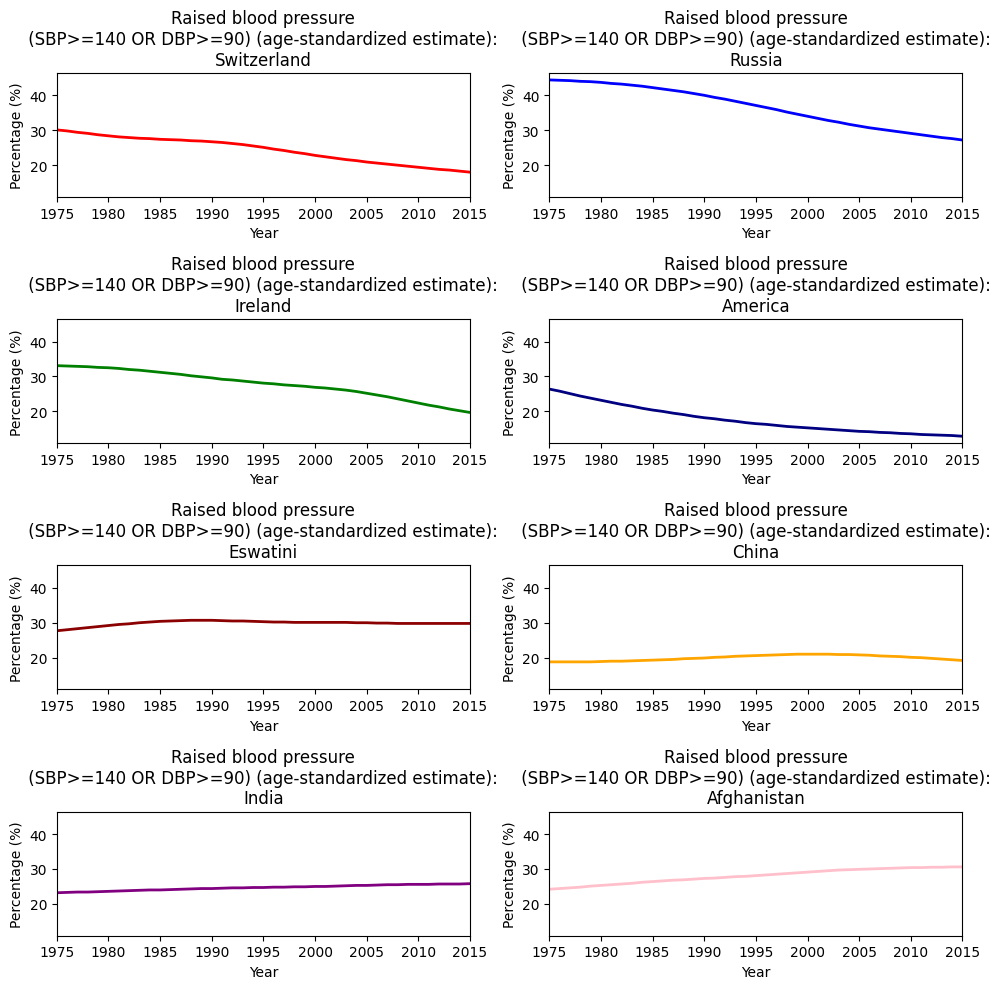

In [25]:
fig = plt.figure(figsize=(10,10))
for i, country_code in enumerate(country_codes):
    axc = fig.add_subplot(4, 2, i+1)
    df = drop_zero(df_countries[country_code],"BP_04")
    ax = df["BP_04"].plot(ax=axc, legend=False, lw=2, color=country_colors[country_code])
    ax.set_title("%s: \n%s" % (indicator_names["BP_04"],country_names[country_code]))
    ax.set_ylabel("Percentage (%)")
    # note that we will use consistent Y-axis limits based on the ranges we computed above
    ax.set_ylim(df_stats["BP_04"]["Min"].min()-2, df_stats["BP_04"]["Max"].max()+2)
    ax.set_xlim(df["BP_04"].index.min(), df["BP_04"].index.max())
    
# fix the spacing between plots
fig.tight_layout()

We can see the  trend  of raised blood pressure change in this map.Four developed countries appear to have a decrease trend, and four developing countries appear to have a small increase trend.

bar plots for each city

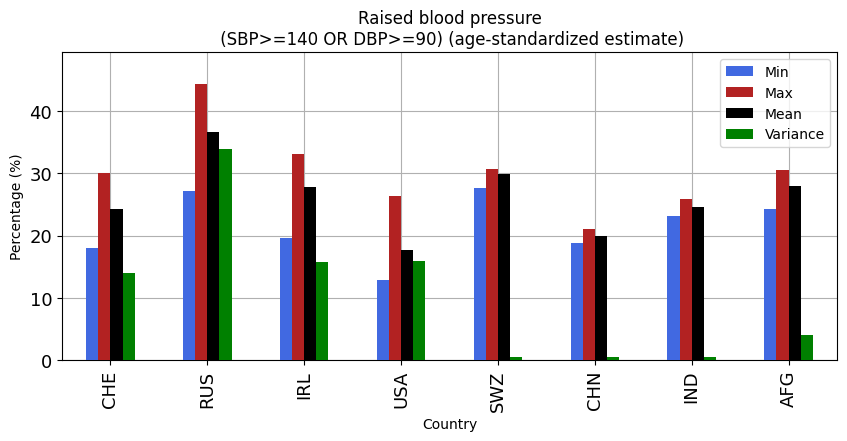

In [26]:
ax = df_stats["BP_04"].plot.bar(figsize=(10,4),y=['Min', 'Max','Mean',"Variance"],
color={ "Min": "royalblue", "Max": "firebrick" , "Mean": "black" ,"Variance":"green"}, fontsize=fontsize, zorder=3)
ticklabels = [d for d in df_stats["BP_04"].index]
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
ax.set_title(indicator_names["BP_04"])
ax.set_ylabel("Percentage (%)")
ax.set_ylim(0, df_stats["BP_04"]["Max"].max()+5)
ax.yaxis.grid(True)
ax.xaxis.grid(True)

We can find in the bar plots that max and min in developed countries have big difference and they also have big Variance. While in developing countries, 
the diffenrece between max and min is very small and the Variance is very low. We also can see that Russia has the highest max,mean and variance value, and the value of min just smaller than Eswatini.

Raised blood pressure in same plt

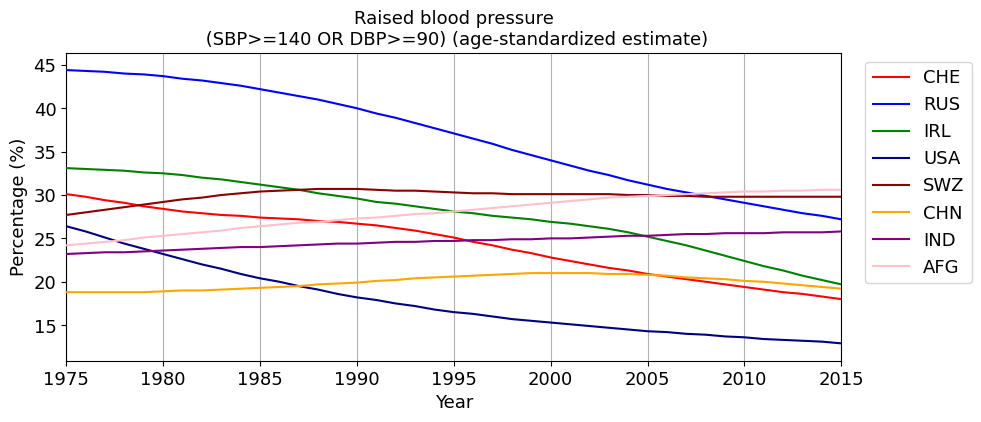

In [27]:
ax = df_merged["BP_04"].plot(figsize=(10,4), color=country_colors, fontsize=fontsize, zorder=3)
ax.set_title(indicator_names["BP_04"], fontsize=fontsize)
ax.set_xlabel("Year", fontsize=fontsize)
ax.set_ylabel("Percentage (%)", fontsize=fontsize)
# adjust the axis limits
ax.set_ylim(df_stats["BP_04"]["Min"].min()-2, df_stats["BP_04"]["Max"].max()+2)
ax.set_xlim(df_merged["BP_04"].index.min(), df_merged["BP_04"].index.max())  
# move the legend outside the plot
ax.legend(bbox_to_anchor=(1.18, 1), fontsize=fontsize)
# add x grid
ax.xaxis.grid(True);

There is a strong different trand in this plt, but is hard to certain.

Lets group them by the development level.

raised blood pressure trend group by development level

In [28]:
developed = ["CHE","RUS","IRL","USA"]
developing = ["SWZ","CHN","IND","AFG"]

add mean value 

In [29]:
df_developing = df_merged["BP_04"][developing]
df_developing["Mean"] = df_developing.apply(lambda x:x.mean(),axis = 1)
df_developed = df_merged["BP_04"][developed]
df_developed["Mean"] = df_developed.apply(lambda x:x.mean(),axis = 1)


/var/folders/gw/h7bnrp551lb8_s2pgrdyqh580000gn/T/ipykernel_2938/3856339848.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_developing["Mean"] = df_developing.apply(lambda x:x.mean(),axis = 1)
/var/folders/gw/h7bnrp551lb8_s2pgrdyqh580000gn/T/ipykernel_2938/3856339848.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_developed["Mean"] = df_developed.apply(lambda x:x.mean(),axis = 1)


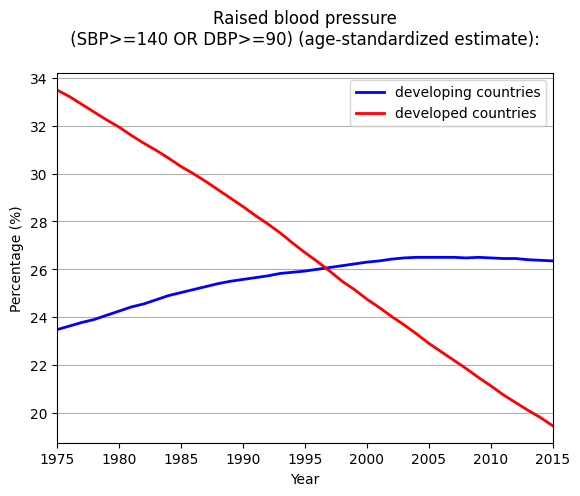

In [30]:
ax = df_developing["Mean"].plot(legend=True, lw=2, color="blue",label='developing countries')
ax = df_developed["Mean"].plot(legend=True, lw=2, color="red",label='developed countries')
ax.set_title("%s: \n" % (indicator_names["BP_04"]))
ax.set_ylabel("Percentage (%)")
ax.set_xlim(df.index.min(), df.index.max());

ax.yaxis.grid(True);

Now we can see the strong different trand in this two development level group.

In view of the opposite trend of these data, we use the correlation to analyze. 

In [31]:
def plot_heatmap(title, df_in, figsize=(5, 5)):
    df_corr = df_in.corr()
    # create a color palettte
    cmap = sns.diverging_palette(114, 514, as_cmap=True)
    # display the heatmap
    f, ax = plt.subplots(figsize=figsize)
    sns.heatmap(df_corr, square=True, cbar=False,
                annot=True, cmap=cmap, linewidths=0.5, vmin=-1)
    ax.set_title(title)

In [32]:
df_merged["BP_04"].head()

,CHE,RUS,IRL,USA,SWZ,CHN,IND,AFG
Year,,,,,,,,
1975,30.1,44.4,33.1,26.4,27.7,18.8,23.2,24.2
1976,29.8,44.3,33.0,25.8,28.0,18.8,23.3,24.4
1977,29.4,44.2,32.9,25.1,28.3,18.8,23.4,24.6
1978,29.1,44.0,32.8,24.4,28.6,18.8,23.4,24.8
1979,28.7,43.9,32.6,23.8,28.9,18.8,23.5,25.1


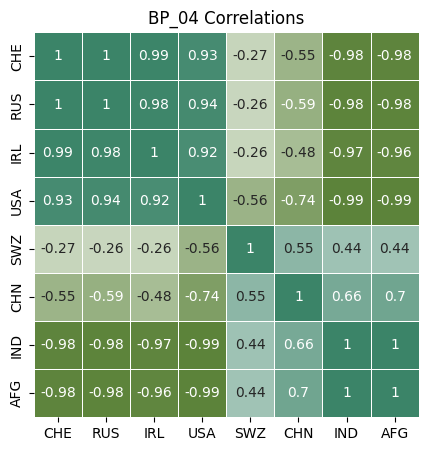

In [33]:
plot_heatmap("BP_04 Correlations", df_merged["BP_04"])

In this heat map, we find that the four developed country have a very strong positive correlation, they have very strong negative correlation with 
India and Afghanistan, mid negative correlation with China and weak negative correlation with Eswatini.

### Raised fasting blood glucose

raised fasting blood glucose of different country

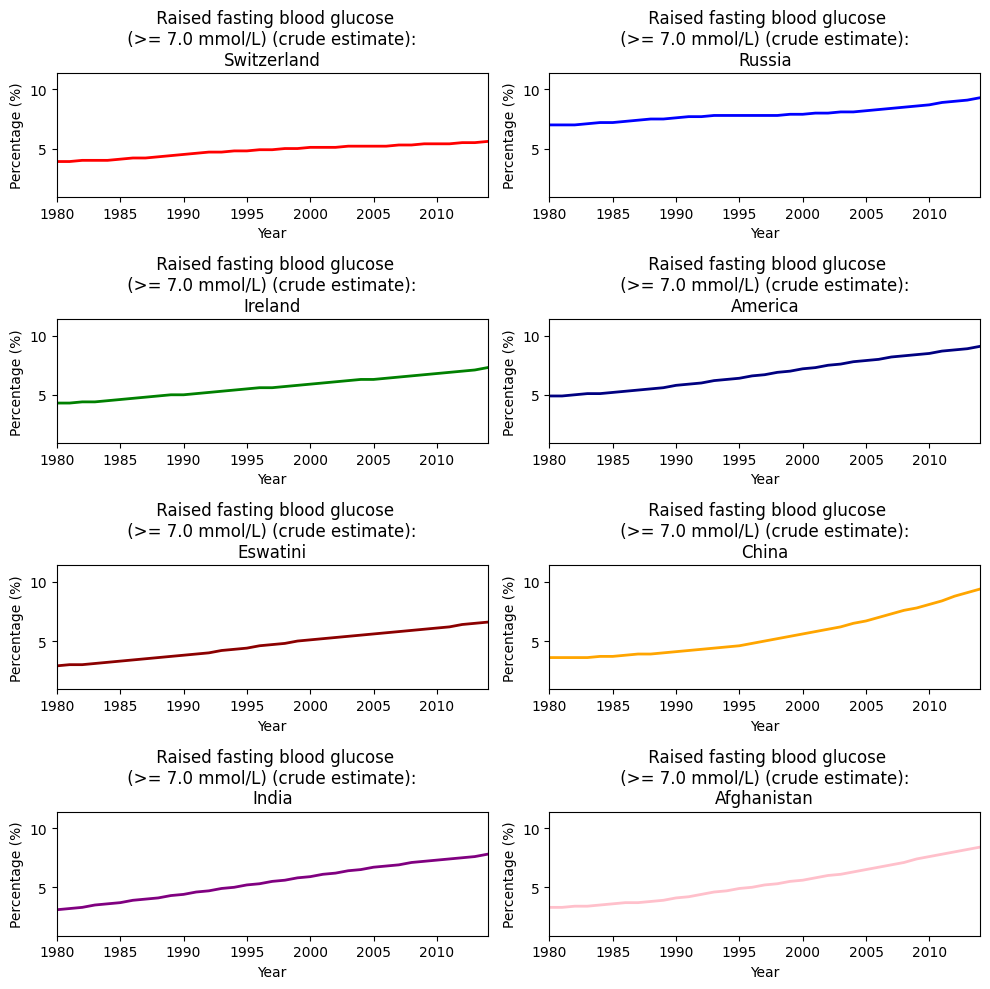

In [34]:
fig = plt.figure(figsize=(10,10))
for i, country_code in enumerate(country_codes):
    axc = fig.add_subplot(4, 2, i+1)
    df = drop_zero(df_countries[country_code],"NCD_GLUC_03")
    ax = df["NCD_GLUC_03"].plot(ax=axc, legend=False, lw=2, color=country_colors[country_code])
    ax.set_title("%s: \n%s" % (indicator_names["NCD_GLUC_03"],country_names[country_code]))
    ax.set_ylabel("Percentage (%)")
    # note that we will use consistent Y-axis limits based on the ranges we computed above
    ax.set_ylim(df_stats["NCD_GLUC_03"]["Min"].min()-2, df_stats["NCD_GLUC_03"]["Max"].max()+2)
    ax.set_xlim(df["NCD_GLUC_03"].index.min(), df["NCD_GLUC_03"].index.max())
    
# fix the spacing between plots
fig.tight_layout()

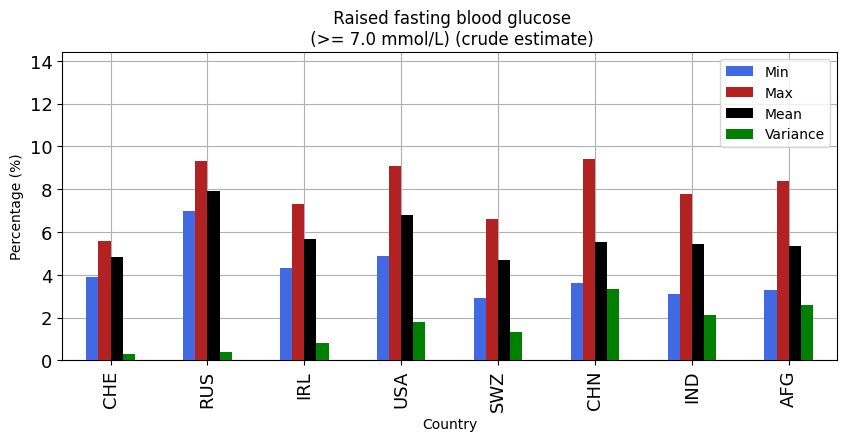

In [35]:
ax = df_stats["NCD_GLUC_03"].plot.bar(figsize=(10,4),y=['Min', 'Max','Mean',"Variance"],
color={ "Min": "royalblue", "Max": "firebrick" , "Mean": "black" ,"Variance":"green"}, fontsize=fontsize, zorder=3)
ticklabels = [d for d in df_stats["NCD_GLUC_03"].index]
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
ax.set_title(indicator_names["NCD_GLUC_03"])
ax.set_ylabel("Percentage (%)")
ax.set_ylim(0, df_stats["NCD_GLUC_03"]["Max"].max()+5)
ax.yaxis.grid(True)
ax.xaxis.grid(True)

The trend looks the same in the eight country.

### Prevalence of obesity among adults

Prevalence of obesity among adults of different country

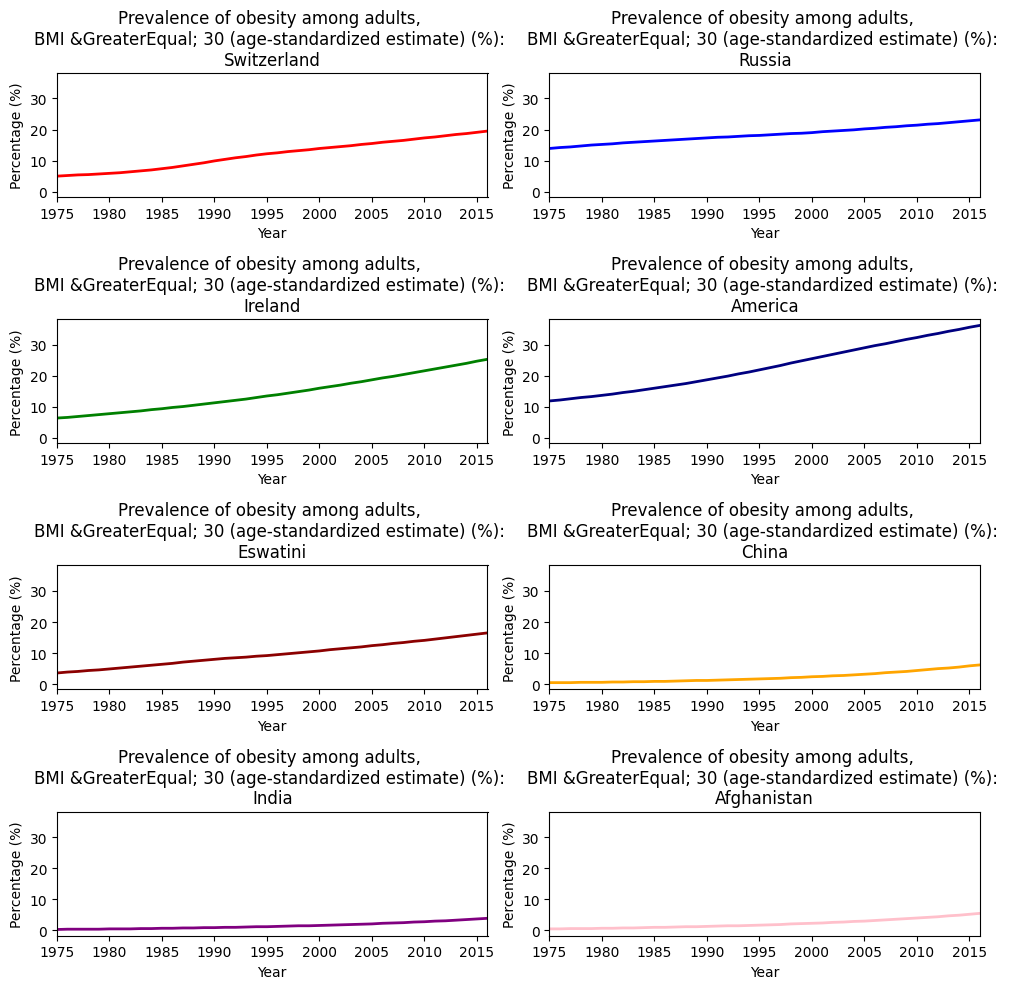

In [36]:
fig = plt.figure(figsize=(10,10))
for i, country_code in enumerate(country_codes):
    axc = fig.add_subplot(4, 2, i+1)
    df = drop_zero(df_countries[country_code],"NCD_BMI_30A")
    ax = df["NCD_BMI_30A"].plot(ax=axc, legend=False, lw=2, color=country_colors[country_code])
    ax.set_title("%s: \n%s" % (indicator_names["NCD_BMI_30A"],country_names[country_code]))
    ax.set_ylabel("Percentage (%)")
    # note that we will use consistent Y-axis limits based on the ranges we computed above
    ax.set_ylim(df_stats["NCD_BMI_30A"]["Min"].min()-2, df_stats["NCD_BMI_30A"]["Max"].max()+2)
    ax.set_xlim(df["NCD_BMI_30A"].index.min(), df["NCD_BMI_30A"].index.max())
    
# fix the spacing between plots
fig.tight_layout()

We find that all the value are increasing each year. But the acceleration of the first five country is bigger than the last three country.


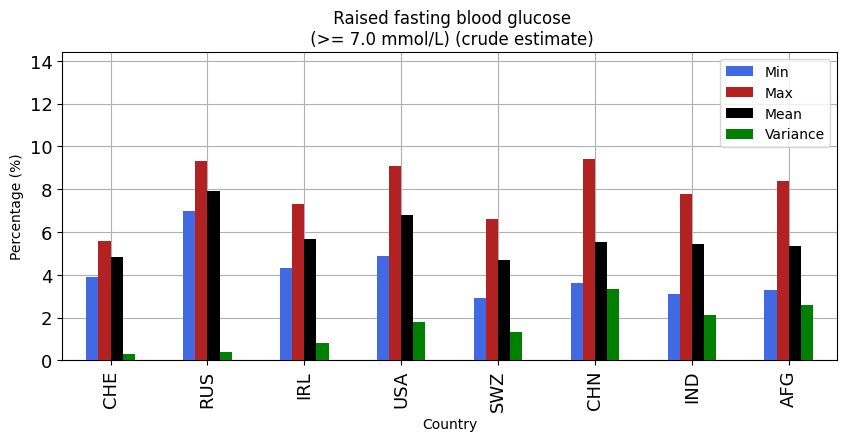

In [37]:
ax = df_stats["NCD_GLUC_03"].plot.bar(figsize=(10,4),y=['Min', 'Max','Mean',"Variance"],
color={ "Min": "royalblue", "Max": "firebrick" , "Mean": "black" ,"Variance":"green"}, fontsize=fontsize, zorder=3)
ticklabels = [d for d in df_stats["NCD_GLUC_03"].index]
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
ax.set_title(indicator_names["NCD_GLUC_03"])
ax.set_ylabel("Percentage (%)")
ax.set_ylim(0, df_stats["NCD_GLUC_03"]["Max"].max()+5)
ax.yaxis.grid(True)
ax.xaxis.grid(True)

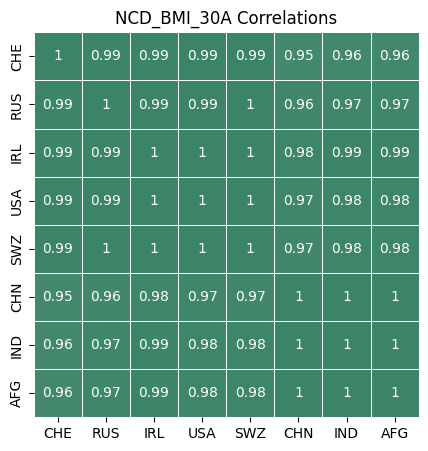

In [38]:
plot_heatmap("NCD_BMI_30A Correlations", df_merged["NCD_BMI_30A"])

All the countries have strong posstive correlation with other countries

### NCD_BMI_PLUS2C

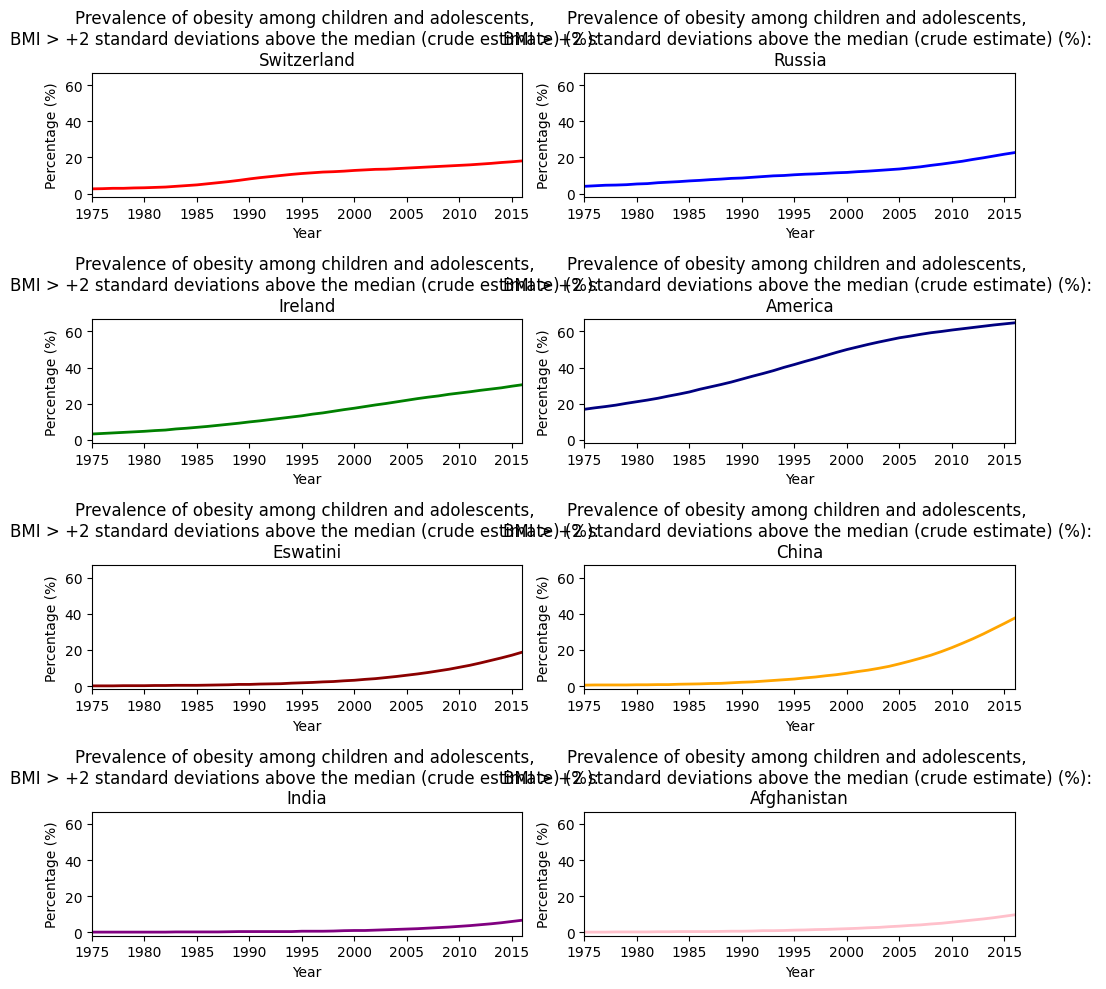

In [39]:
fig = plt.figure(figsize=(10,10))
for i, country_code in enumerate(country_codes):
    axc = fig.add_subplot(4, 2, i+1)
    df = drop_zero(df_countries[country_code],"NCD_BMI_PLUS2C")
    ax = df["NCD_BMI_PLUS2C"].plot(ax=axc, legend=False, lw=2, color=country_colors[country_code])
    ax.set_title("%s: \n%s" % (indicator_names["NCD_BMI_PLUS2C"],country_names[country_code]))
    ax.set_ylabel("Percentage (%)")
    # note that we will use consistent Y-axis limits based on the ranges we computed above
    ax.set_ylim(df_stats["NCD_BMI_PLUS2C"]["Min"].min()-2, df_stats["NCD_BMI_PLUS2C"]["Max"].max()+2)
    ax.set_xlim(df["NCD_BMI_PLUS2C"].index.min(), df["NCD_BMI_PLUS2C"].index.max())
    
# fix the spacing between plots
fig.tight_layout()

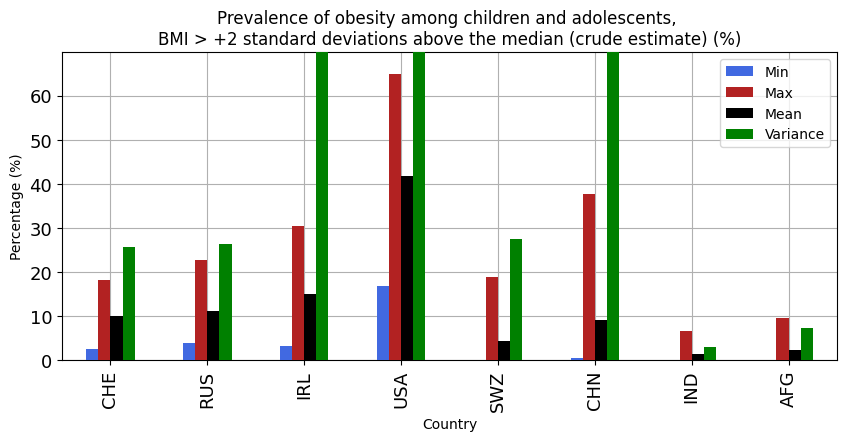

In [40]:
ax = df_stats["NCD_BMI_PLUS2C"].plot.bar(figsize=(10,4),y=['Min', 'Max','Mean',"Variance"],
color={ "Min": "royalblue", "Max": "firebrick" , "Mean": "black" ,"Variance":"green"}, fontsize=fontsize, zorder=3)
ticklabels = [d for d in df_stats["NCD_BMI_PLUS2C"].index]
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
ax.set_title(indicator_names["NCD_BMI_PLUS2C"])
ax.set_ylabel("Percentage (%)")
ax.set_ylim(0, df_stats["NCD_BMI_PLUS2C"]["Max"].max()+5)
ax.yaxis.grid(True)
ax.xaxis.grid(True)

We find that Variance are very different in this plot,Ireland,USA and China have big variances. Switzer,Eswatini and Russia have middle variances. India and afghanistan have very low variances.

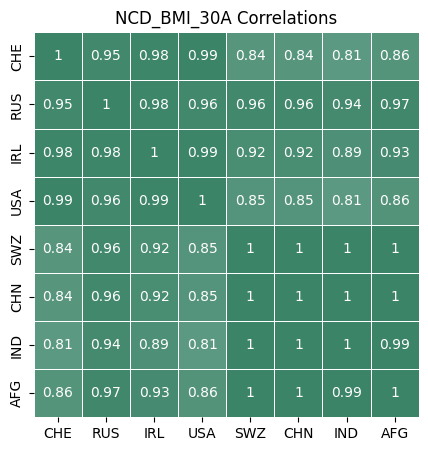

In [41]:
plot_heatmap("NCD_BMI_30A Correlations", df_merged["NCD_BMI_PLUS2C"])

We can see the small differences between developed and developing countries in the correlated map.

## Raised fasting blood glucose and Raised blood pressure

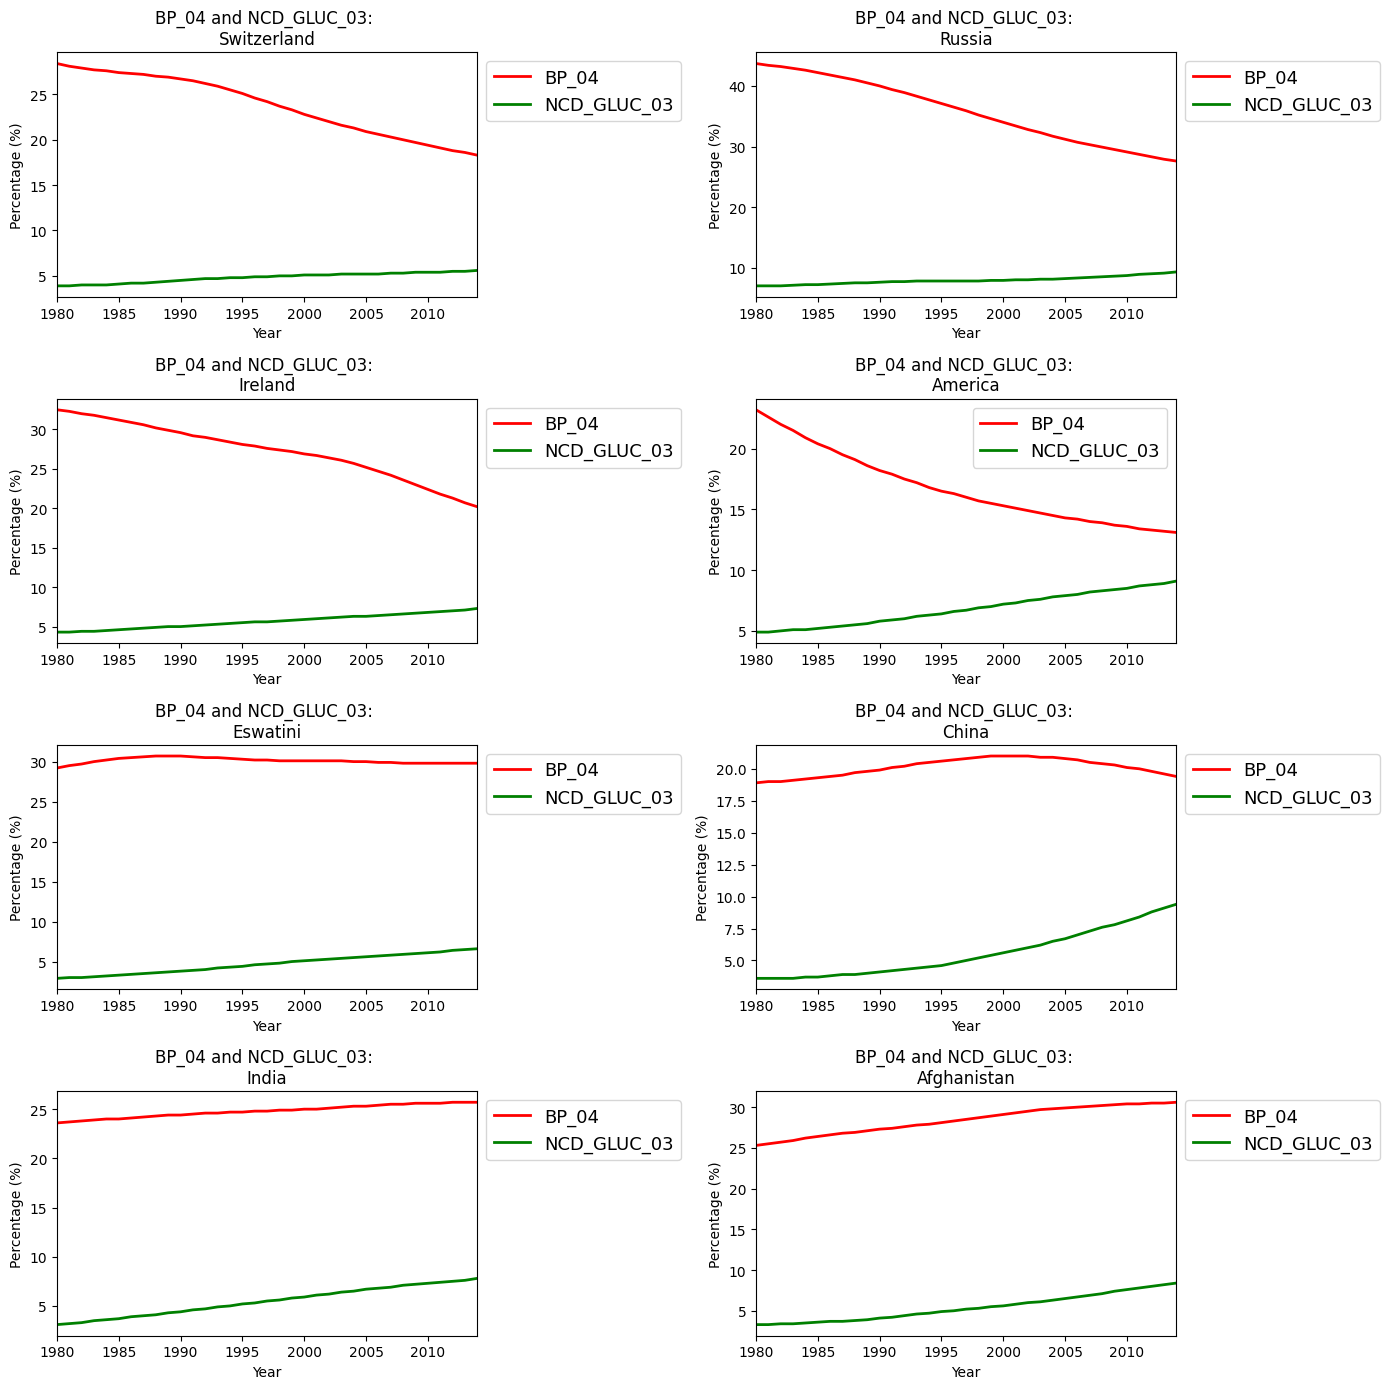

In [42]:
fig = plt.figure(figsize=(14,14))
for i, country_code in enumerate(country_codes):
    axc = fig.add_subplot(4,2, i+1)
    df = drop_zero(df_countries[country_code],"BP_04","NCD_GLUC_03")
    ax = df["BP_04"].plot(ax=axc, legend=False, lw=2, color="red")
    ax = df["NCD_GLUC_03"].plot(ax=axc, legend=False, lw=2, color="green")
    ax.set_title("%s: \n%s" % ("BP_04 and NCD_GLUC_03",country_names[country_code]))
    ax.set_ylabel("Percentage (%)")
    # note that we will use consistent Y-axis limits based on the ranges we computed above
    #ax.set_ylim(min(df_stats["NCD_BMI_30A"]["Min"].min(),df_stats["NCD_BMI_30A"]["Min"].min())-2, max(df_stats["NCD_BMI_30A"]["Max"].max(),df_stats["NCD_BMI_30A"]["Max"].max())+2)
    ax.set_xlim(df.index.min(), df.index.max())
    ax.legend(bbox_to_anchor=(1, 1), fontsize=fontsize)
    
# fix the spacing between plots
fig.tight_layout()

We can see that in developing countries, Raised fasting blood glucose and Raised blood pressure present the same trend. While in developed countries,
Raised fasting blood glucose and Raised blood pressure present the opposite trend.

### Adolescent malnutrition and overweight

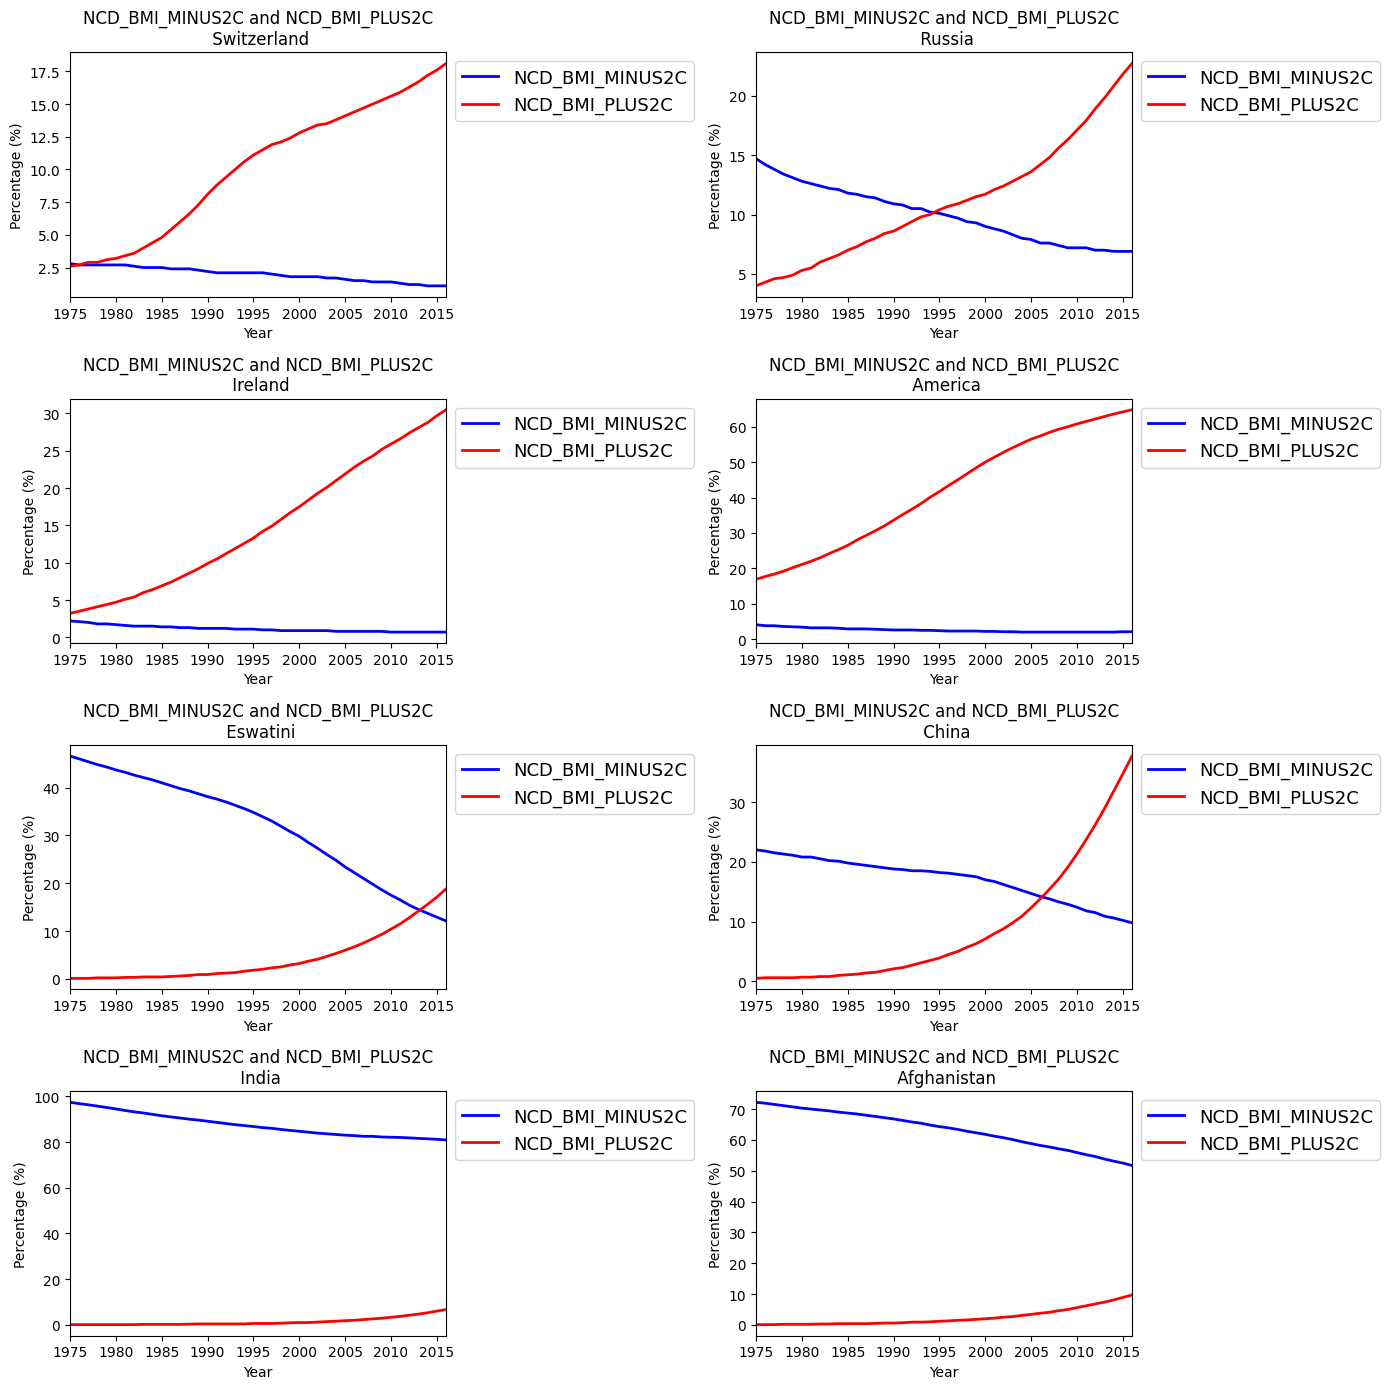

In [43]:
fig = plt.figure(figsize=(14,14))
for i, country_code in enumerate(country_codes):
    axc = fig.add_subplot(4,2, i+1)
    df = drop_zero(df_countries[country_code],"NCD_BMI_MINUS2C","NCD_BMI_PLUS2C")
    ax = df["NCD_BMI_MINUS2C"].plot(ax=axc, legend=False, lw=2, color="blue")
    ax = df["NCD_BMI_PLUS2C"].plot(ax=axc, legend=False, lw=2, color="red")
    ax.set_title("NCD_BMI_MINUS2C and NCD_BMI_PLUS2C\n %s"%country_names[country_code])
    ax.set_ylabel("Percentage (%)")
    # note that we will use consistent Y-axis limits based on the ranges we computed above
    #ax.set_ylim(min(df_stats["NCD_BMI_MINUS2C"]["Min"].min(),df_stats["NCD_BMI_PLUS2C"]["Min"].min())-2, max(df_stats["NCD_BMI_MINUS2C"]["Max"].max(),df_stats["NCD_BMI_PLUS2C"]["Max"].max())+2)
    ax.set_xlim(df.index.min(), df.index.max())
    ax.legend(bbox_to_anchor=(1, 1), fontsize=fontsize)
    
# fix the spacing between plots
fig.tight_layout()

we can see that Switzerland, USA and Ireland have same pattern, China, Eswatini and Russia have same pattern and India and Afghanistan have same pattern.

we can infer that India and Afghanistan pattern is the early stage, which malnutrition is very high and decrised slowly and overweight value increased slowly.

China, Eswatini and Russia pattern is the middle stage, which malnutrition decrised fastly and overweight value increased fastly, and the two curves intersected in this period.

Switzerland, USA and Ireland pattern is the later stage, which malnutrition is very low and still decrise slowly and overweight value increased fastly.

### Raised fasting blood glucose and overweight

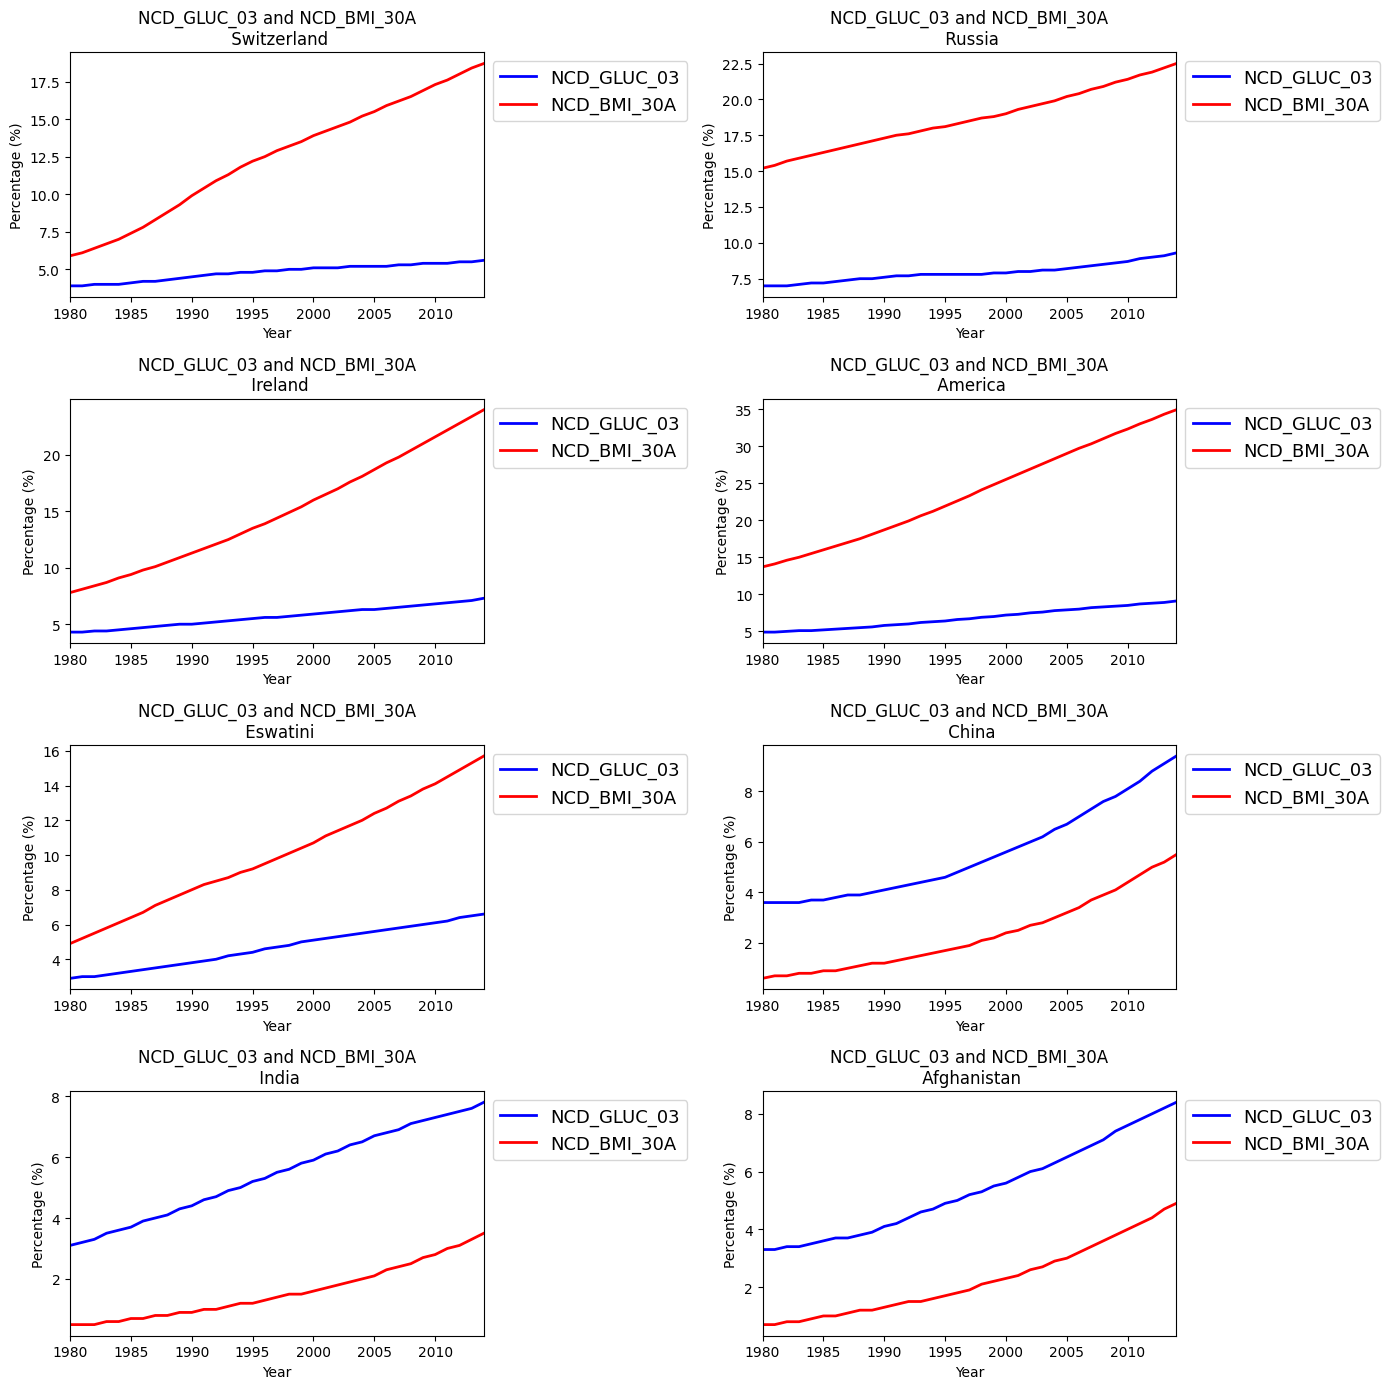

In [44]:
fig = plt.figure(figsize=(14,14))
#"NCD_BMI_30A", "NCD_GLUC_03", "BP_04", "NCD_BMI_18A", "NCD_BMI_PLUS2C", "NCD_BMI_MINUS2C"
for i, country_code in enumerate(country_codes):
    axc = fig.add_subplot(4,2, i+1)
    df = drop_zero(df_countries[country_code],"NCD_GLUC_03","NCD_BMI_30A")
    ax = df["NCD_GLUC_03"].plot(ax=axc, legend=False, lw=2, color="blue")
    ax = df["NCD_BMI_30A"].plot(ax=axc, legend=False, lw=2, color="red")
    ax.set_title("NCD_GLUC_03 and NCD_BMI_30A\n %s"%country_names[country_code])
    ax.set_ylabel("Percentage (%)")
    # note that we will use consistent Y-axis limits based on the ranges we computed above
    #ax.set_ylim(min(df_stats["NCD_BMI_MINUS2C"]["Min"].min(),df_stats["NCD_BMI_PLUS2C"]["Min"].min())-2, max(df_stats["NCD_BMI_MINUS2C"]["Max"].max(),df_stats["NCD_BMI_PLUS2C"]["Max"].max())+2)
    ax.set_xlim(df.index.min(), df.index.max())
    ax.legend(bbox_to_anchor=(1, 1), fontsize=fontsize)
    
# fix the spacing between plots
fig.tight_layout()

We can see a very strong relationship between Raised fasting blood glucose and overweight in the map.

### Correlations Between Variables

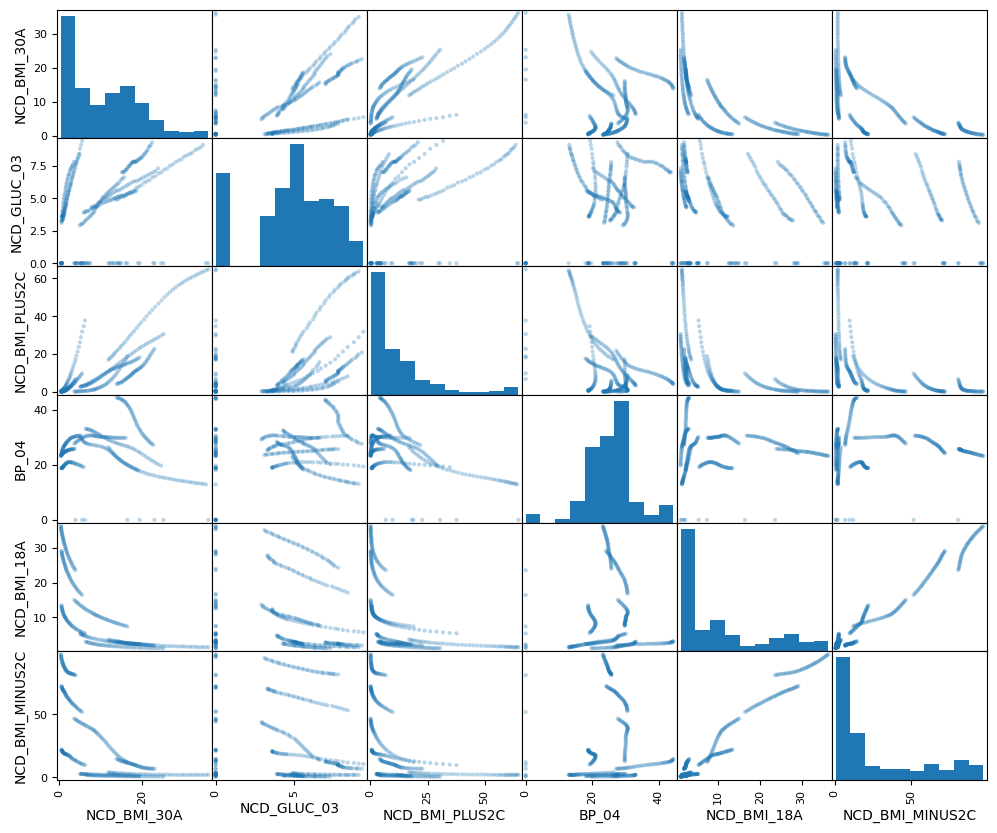

In [45]:
dfs = []
for country_name in country_names:
    dfs.append(df_countries[country_name].reset_index())
df_all = pd.concat(dfs)
df_all.head()
df_all2 = df_all[indicator_codes]
ax = scatter_matrix(df_all2, figsize=(12,10), alpha=0.3)

heat map of Correlations of Between Variables for each country

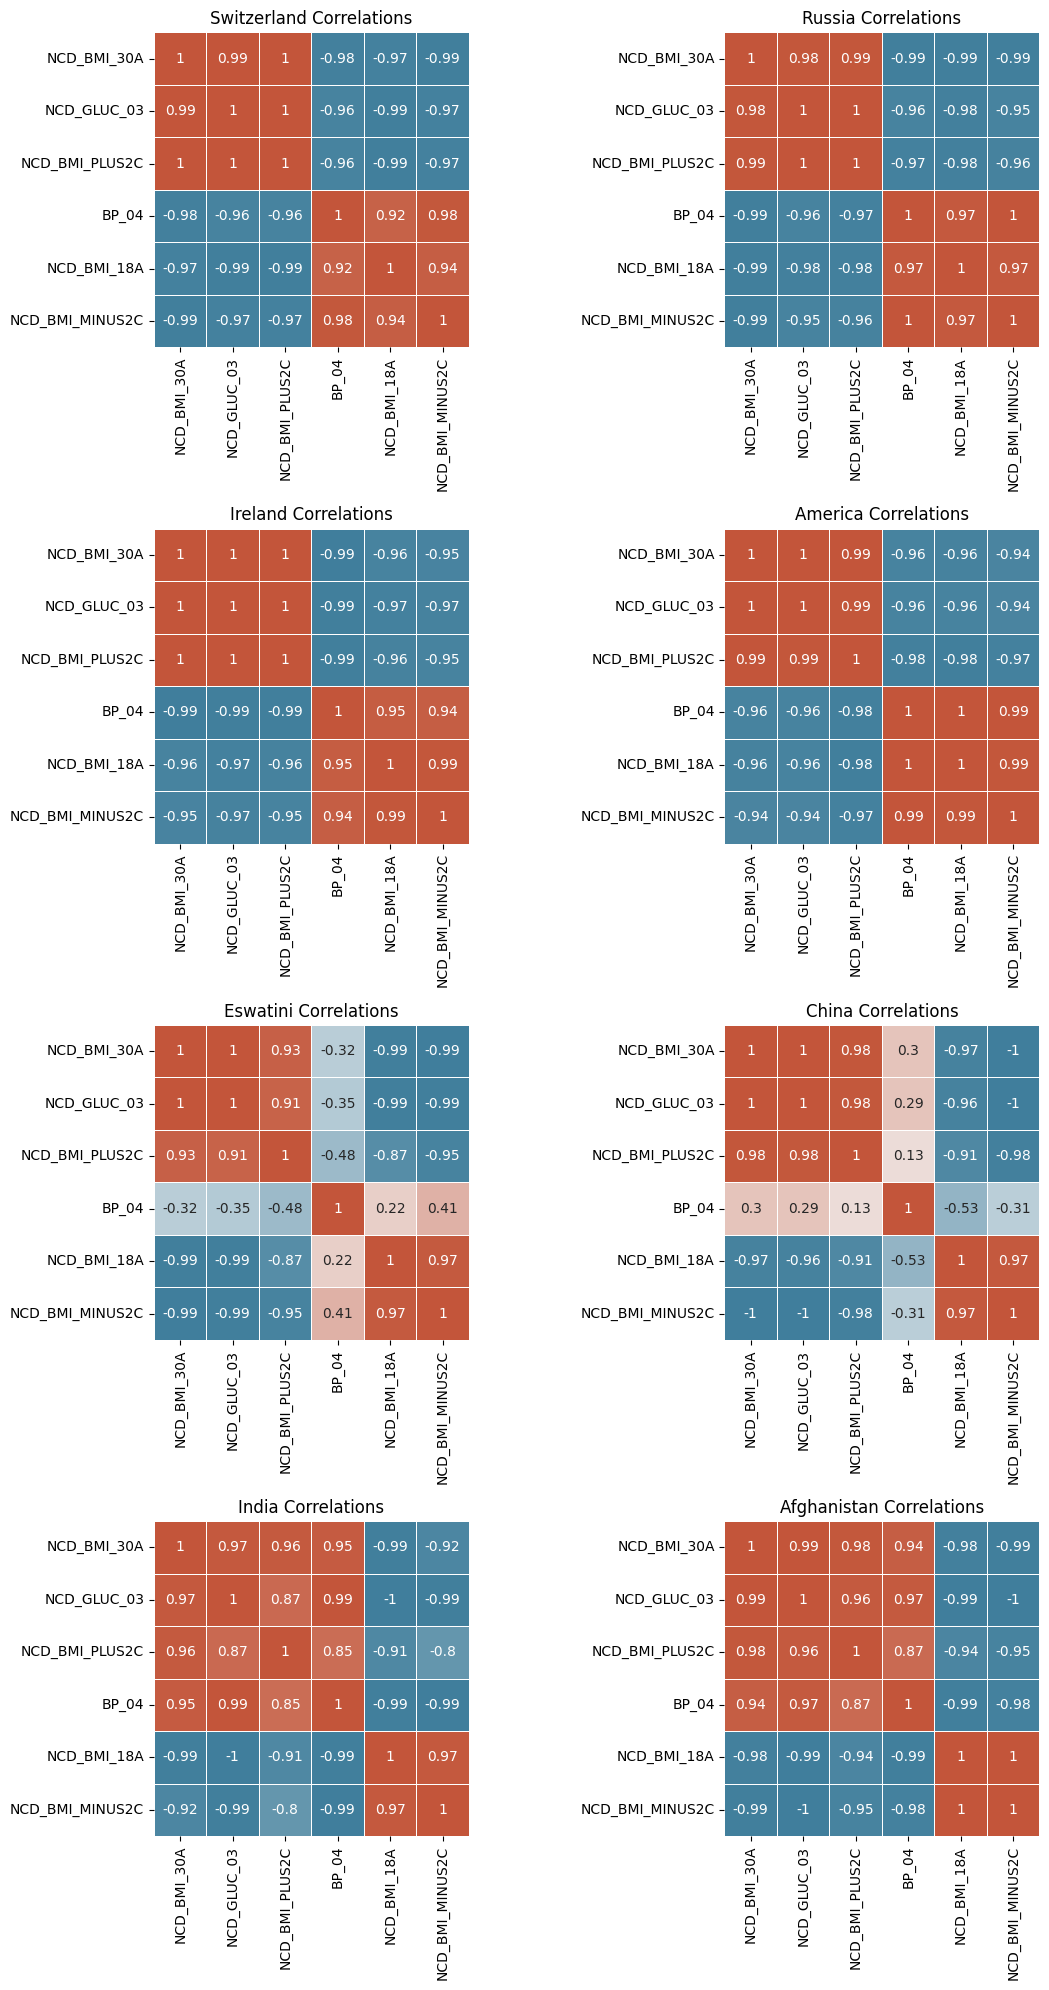

In [46]:
#fig = plt.figure(figsize=(14,7))
f, axs = plt.subplots(4, 2, figsize=(12, 20), gridspec_kw=dict(width_ratios=[3, 3]))
for i, country_code in enumerate(country_codes):
    ax = axs[i//2][i%2]
    df_in = drop_zero(drop_zero(df_countries[country_code][indicator_codes],codes = indicator_codes))
    df_corr = df_in.corr()
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(df_corr, square=True, cbar=False,
                annot=True, cmap=cmap, linewidths=0.5, vmin=-1,ax = ax)
    ax.set_title(country_names[country_code]+" Correlations")
f.tight_layout()

We can see that the four developed country have the same patten again. 

While for the developing country, India and Afghanistan has the same patten.

China and Eswatinis' patten is also different than India and Afghanistan, which may hint that these four developing country are in different stage.

# Conclusions

In this assignment we analysied the year data of 8 countries(half of them are developed country and other half are developing country), each country incloud six
indicator(underweight,overweight,underweight(children),overweight(children), Raised blood pressure, Raised fasting blood glucose). In general, developed country and
 developing country have distinguishable patten. While some times three different patten appears, for example the trend of underweight and overweight.
 
The challenge of WHO api is that they have huge number of indicators, and each indicator contain different years. We write a func to find how many years the indicator contains and chose indicators who may have correlationship. In order to get the most data, we don't make the data have same time range when we Preprocessing data. As an alternative, we write two function
to allow me get year range flexible. 

In the future: Our code is extensible. The program compatibility with country_related extensions and also make the extensibility of indicator as much as possible. We can change the country or the indicators according to our future needs.